# Plotting and metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# import signatory
import iisignature
import torch

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import sys
sys.path.append('../src')
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config

## Define model names and synthetic datasets

In [2]:
model_names = [
    "train_data", # the train data is not a model, but it is used in the plotting
    # "knn",
    # "gbm", 
    # "sabr",
    # "heston",
    # "r_bergomi",
    "t_forcing",
    # "diffusion_ts",
    # "sbts",
    "quant_gan",
    # "time_gan",
    "tc_vae",
    "time_vae"
]

model_color = {
    "train_data": "#000000",
    "knn": "#92d051",
    "gbm": "#aab8de",
    "sabr": "#156fd6", 
    "heston": "#3d569a",
    "r_bergomi": "#702fa0",
    "t_forcing": "#00b050",
    "diffusion_ts": "#6c1816",
    "sbts": "#e6837f",
    "quant_gan": "#826020",
    "time_gan": "#dbb368",
    "tc_vae": "#dc7103",
    "time_vae": "#ffc003"
}

model_names_pretty = {
    "train_data": "Train Data",
    "knn": "KNN",
    "gbm": "GBM",
    "sabr": "SABR",
    "heston": "Heston",
    "r_bergomi": "rBergomi",
    "t_forcing": "T-Forcing",
    "diffusion_ts": "Diffusion-TS",
    "sbts": "SBTS",
    "quant_gan": "QuantGAN",
    "time_gan": "TimeGAN",
    "tc_vae": "TC-VAE",
    "time_vae": "TimeVAE",
}

synth_data_sets = []
for model_name in model_names:
    if model_name == "train_data":
        train_data = pd.read_csv("../data/raw/spy_daily_closing_prices_train.csv", index_col=0)
        train_data = train_data["Close"]
        train_data = train_data/train_data.iloc[0]
        continue
    synth_data = pd.read_csv(f"../data/processed/{model_name}_synth_data.csv", index_col=0)
    synth_data = post_processing(synth_data, **post_processing_config) # remove this
    synth_data_sets.append(synth_data)


## Define visualization functions and loading data

In [3]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices_train.csv", index_col=0)
train_data = train_data["Close"]
train_data = train_data/train_data.iloc[0]
train_data_seq = np.array([train_data.values[i:i+30] for i in range(len(train_data)-30 + 1)])
train_data_seq = pd.DataFrame(train_data_seq)
train_data_seq = train_data_seq.div(train_data_seq.iloc[:, 0], axis=0)

val_data = pd.read_csv("../data/raw/spy_daily_closing_prices_val.csv", index_col=0)
val_data = val_data["Close"]
val_data = np.array([val_data.values[i:i+30] for i in range(len(val_data)-30 + 1)])
val_data = pd.DataFrame(val_data)
val_data = val_data.div(val_data.iloc[:, 0], axis=0)

test_data = pd.read_csv("../data/raw/spy_daily_closing_prices_test.csv", index_col=0)
test_data = test_data["Close"]
test_data = np.array([test_data.values[i:i+30] for i in range(len(test_data)-30 + 1)])
test_data = pd.DataFrame(test_data)
test_data = test_data.div(test_data.iloc[:, 0], axis=0)

In [4]:
def plot_autocorrelation(df: pd.DataFrame, model_name: str, data_type: str):
    """
    Plots the autocorrelation at a given lag for each timeseries.

    Parameters:
    - df: pd.DataFrame of shape (num_series, num_timesteps) for synthetic data, or (num_timesteps,) for training data. Price paths.
    - model_name: str, the name of the model.
    - data_type: str, either returns or absolute returns
    """
    
    if model_name == "train_data":
        # For training data (one long time series)
        log_returns = np.log(df/df.shift()).dropna()
        if data_type == "returns":
            X = log_returns.values.reshape(-1, 1)
        elif data_type == "absolute_returns":
            X = np.abs(log_returns).values.reshape(-1, 1)
    else:
        # For synthetic data (multiple series)
        log_returns = np.log(df/df.shift(axis=1)).dropna(axis=1)
        if data_type == "returns":
            X = log_returns.values
        elif data_type == "absolute_returns":
            X = np.abs(log_returns).values

    N, M = X.shape

    # Compute the ensemble autocovariance and autocorrelation
    max_lag = 29  # adjust as needed
    gamma = np.zeros(max_lag + 1)

    # Overall mean across all data points
    mu = X.mean()

    for k in range(max_lag + 1):
        prod = (X[:N - k] - mu) * (X[k:] - mu)
        gamma[k] = prod.sum() / (M * (N - k))

    rho = gamma / gamma[0]  # normalize to get autocorrelation

    # Plot the ACF
    lags = np.arange(max_lag + 1)
    plt.stem(lags, rho, linefmt=model_color[model_name], markerfmt='o', basefmt=model_color[model_name])
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title(f"Autocorrelation Plot for {model_names_pretty[model_name]}")
    plt.show()

def plot_return_tails(train_data: pd.DataFrame, synth_data: pd.DataFrame, model_name: str, use_kde: bool = False):
    """
    Plot the distribution of absolute returns compared to normal distribution.
    
    Args:
        train_data (pd.DataFrame): DataFrame of shape (num_timesteps,)
        synth_data (pd.DataFrame): DataFrame of shape (num_series, num_timesteps)
        model_name (str): Name of the model
        use_kde (bool): Whether to use kernel density estimation for smoothing
    """
    # Calculate log returns for all series
    # Calculate returns for training data (1D series)
    train_returns = np.log(train_data/train_data.shift()).dropna()
    synth_returns = np.log(synth_data/synth_data.shift(axis=1)).dropna(axis=1)
    abs_train_returns = np.abs(train_returns).values
    abs_synth_returns = np.abs(synth_returns).values.flatten()
    
    # Sort returns and calculate empirical probabilities
    sorted_train_returns = np.sort(abs_train_returns)
    p_train = 1. - np.arange(len(sorted_train_returns)) / len(sorted_train_returns)
    
    sorted_synth_returns = np.sort(abs_synth_returns)
    p_synth = 1. - np.arange(len(sorted_synth_returns)) / len(sorted_synth_returns)
    
    # Generate normal distribution with same mean and std as training data
    mean = np.mean(abs_train_returns)
    std = np.std(abs_train_returns)
    sorted_normal = sorted_train_returns
    p_normal = 1 - stats.norm.cdf(sorted_normal, loc=mean, scale=std)
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    if use_kde:
        # Fit KDE to the empirical quantiles
        kde_train = stats.gaussian_kde(sorted_train_returns, bw_method=1, weights=p_train)
        kde_synth = stats.gaussian_kde(sorted_synth_returns, bw_method=1, weights=p_synth)
        
        # Generate points for smooth KDE curves
        x_range = np.linspace(min(sorted_train_returns), max(sorted_synth_returns), 1000)
        kde_train_curve = kde_train(x_range)
        kde_synth_curve = kde_synth(x_range)
        
        # Plot KDE curves with log scale on y-axis
        plt.semilogy(x_range, kde_train_curve, "k-", label="Training Data", alpha=0.7)
        plt.semilogy(x_range, kde_synth_curve, color=model_color[model_name], label='Synthetic Data', alpha=0.7)
        plt.ylim(bottom=min(kde_synth_curve))  # Set y-axis minimum to lowest synthetic density
    else:
        # Plot raw data points
        plt.semilogy(sorted_train_returns, p_train, 'k.', label='Training Data', alpha=0.7, markersize=2)
        plt.semilogy(sorted_synth_returns, p_synth, '.', color=model_color[model_name], label='Synthetic Data', alpha=0.7, markersize=2)
        plt.legend(markerscale=4)  # Makes markers in legend 4x bigger than in plot
        plt.ylim(bottom=min(p_synth))  # Set y-axis minimum to lowest probability
        
    plt.semilogy(sorted_normal, p_normal, 'r-', label='Normal', alpha=0.7)
    plt.xlabel('Absolute Log Returns')
    plt.ylabel('Density')
    plt.title(f'Return Distribution vs Normal for {model_names_pretty[model_name]}')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualization_tsne_pca(ori_data, generated_data, analysis, model_name, compare=3000):
    """Using PCA or tSNE for generated and original data visualization.
  
    Args:
        - ori_data: original data
        - generated_data: generated synthetic data
        - analysis: tsne or pca or kernel
        - model_name: name of the model
    """
    # Analysis sample size (for faster computation)
    # ori_data = np.array(ori_data[["Close"]].values)
    ori_data = np.array([ori_data[i:i+30] for i in range(len(ori_data)-30 + 1)])
    ori_data = ori_data / ori_data[:, 0:1]

    generated_data = np.array(generated_data.values)
    generated_data = generated_data[..., np.newaxis]

    anal_sample_no = min([compare, ori_data.shape[0]])
    idx = np.random.permutation(ori_data.shape[0])[:anal_sample_no]

    # Data preprocessing
    # ori_data = np.asarray(ori_data)
    # generated_data = np.asarray(generated_data)

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    # Visualization parameter
    colors = ["black" for i in range(anal_sample_no)] + [model_color[model_name] for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()
        plt.title(f'PCA plot for {model_names_pretty[model_name]}')
        plt.xlabel('x-pca')
        plt.ylabel('y-pca')
        plt.show()

    elif analysis == 'tsne':

        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # TSNE anlaysis
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()

        plt.title(f't-SNE plot for {model_names_pretty[model_name]}')
        plt.xlabel('x-tsne')
        plt.ylabel('y-tsne')
        plt.show()

    elif analysis == 'kernel':
       
        # Visualization parameter
        # colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

        f, ax = plt.subplots(1)
        sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
        sns.distplot(prep_data_hat, hist=False, kde=True, kde_kws={'linewidth': 5, 'linestyle':'--'}, label='Synthetic', color="blue")
        # Plot formatting

        # plt.legend(prop={'size': 22})
        plt.legend()
        plt.xlabel('Data Value')
        plt.ylabel('Data Density Estimate')
        # plt.rcParams['pdf.fonttype'] = 42

        # plt.savefig(str(args.save_dir)+"/"+args.model1+"_histo.png", dpi=100,bbox_inches='tight')
        # plt.ylim((0, 12))
        plt.show()
        plt.close()


def visualization_signature_tsne(ori_data, generated_data, model_name, compare=3000, signature_level=5):
    """Using path signatures and tSNE for generated and original data visualization.
  
    Args:
        - ori_data: original data
        - generated_data: generated synthetic data
        - model_name: name of the model
        - compare: number of samples to compare
        - signature_level: level of the truncated signature
    """
    # Analysis sample size (for faster computation)
    ori_data = np.array([ori_data[i:i+30] for i in range(len(ori_data)-30 + 1)])
    ori_data = ori_data / ori_data[:, 0:1]

    generated_data = np.array(generated_data.values)
    generated_data = generated_data[..., np.newaxis]

    anal_sample_no = min([compare, ori_data.shape[0]])
    idx = np.random.permutation(ori_data.shape[0])[:anal_sample_no]

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    # Add time component
    time = np.linspace(0, 1, ori_data.shape[1])[np.newaxis, :, np.newaxis]
    time = np.repeat(time, ori_data.shape[0], axis=0)
    
    # Combine time and price data
    ori_data_with_time = np.concatenate([time, ori_data], axis=2)
    generated_data_with_time = np.concatenate([time, generated_data], axis=2)

    # Convert to torch tensors for iisig
    ori_data_tensor = torch.tensor(ori_data_with_time, dtype=torch.float32)
    generated_data_tensor = torch.tensor(generated_data_with_time, dtype=torch.float32)

    # Compute signatures using iisig
    # iisig expects paths in format [batch, length, channels]
    print(1)
    ori_signatures = iisignature.sig(ori_data_tensor, signature_level)
    print(2)
    generated_signatures = iisignature.sig(generated_data_tensor, signature_level)
    print(3)

    # Convert back to numpy
    ori_signatures = ori_signatures.numpy()
    generated_signatures = generated_signatures.numpy()

    # Combine signatures for t-SNE
    combined_signatures = np.concatenate([ori_signatures, generated_signatures], axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    print(4)
    tsne_results = tsne.fit_transform(combined_signatures)
    print(5)

    # Plotting
    f, ax = plt.subplots(1)
    colors = ["black" for i in range(anal_sample_no)] + [model_color[model_name] for i in range(anal_sample_no)]

    plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1],
                c=colors[:anal_sample_no], alpha=0.2, label="Original")
    plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1],
                c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

    ax.legend()
    plt.title(f't-SNE plot with Path Signatures (Level {signature_level}) for {model_names_pretty[model_name]}')
    plt.xlabel('x-tsne')
    plt.ylabel('y-tsne')
    plt.show()

def plot_first_timeseries(data, model_name):
    """
    Plot the first time series from the data.
    
    Args:
        data (np.ndarray): Array of shape (num_series, num_timesteps)
        model_name (str): Name of the model
    """
    
    
    fig, axs = plt.subplots(1, 1, figsize=(6, 4))



    for i in range(100):
        axs.plot(data.iloc[i, :], alpha=0.5)


    axs.set_title(f"10 Timeseries for {model_names_pretty[model_name]}")
    axs.set_xlabel('Time Step')
    axs.set_ylabel('Normalized Price')
    axs.grid(True)

## Plot autocorrelation

In [ ]:
for model_name, data_set in zip(model_names, synth_data_sets):
    plot_autocorrelation(data_set, model_name, "returns")

## Plot return tails

In [ ]:
## Plot return tails
for model_name, data_set in zip(model_names, synth_data_sets):
    if model_name == "train_data":
        continue
    plot_return_tails(train_data, data_set, model_name)


## Plot TSNE and PCA

In [ ]:
## Plot return tails
for model_name, data_set in zip(model_names, synth_data_sets):
    if model_name == "train_data":
        continue
    visualization_tsne_pca(train_data_seq, data_set, "pca", model_name)
    # visualization_tsne_pca(train_data, data_set, "pca", model_name)


In [ ]:
for model_name, data_set in zip(model_names, synth_data_sets):
    if model_name == "train_data":
        continue
    visualization_signature_tsne(train_data_seq, data_set, model_name)
    # visualization_tsne_pca(train_data, data_set, "pca", model_name)


## Plotting timeseries

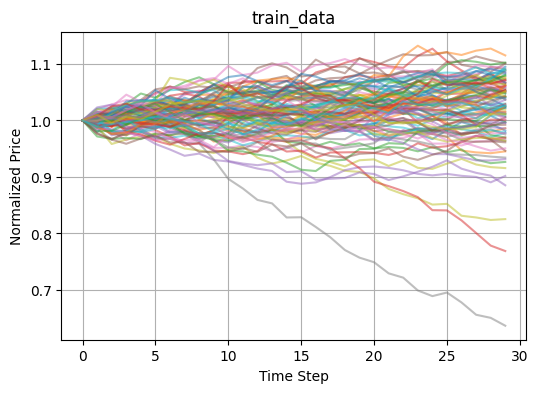

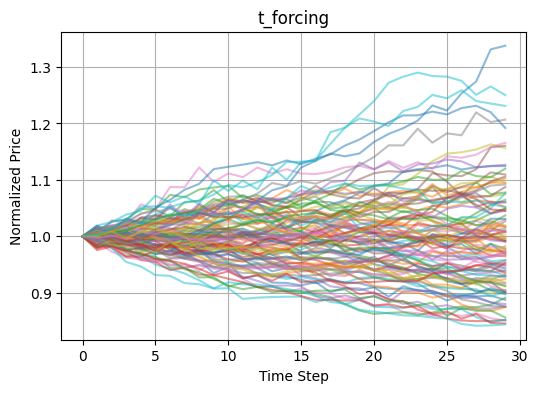

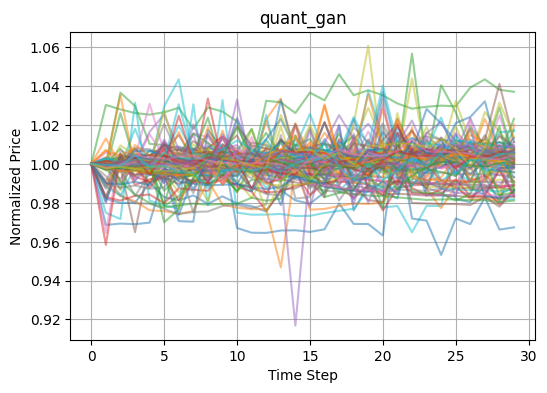

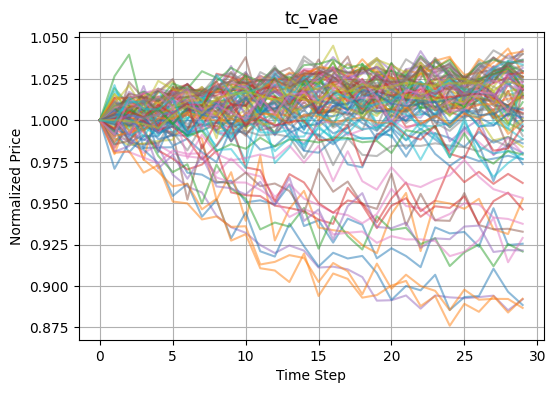

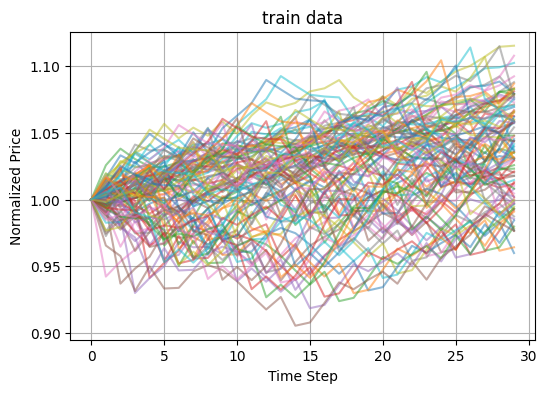

In [73]:
for model_name, data_set in zip(model_names, synth_data_sets):
    plot_first_timeseries(data_set, model_name)

plot_first_timeseries(train_data_seq, "train data")